In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans Mono'
import ubisum

In [2]:
from scipy.interpolate import interp1d
from sklearn.preprocessing import LabelEncoder
import itertools

class Preprocessor():
    def __init__(self, gap_max=1.0, seg_dur=5.0, ol_rate=0.5, resamp_gap=0.01):
        self.gap_max = gap_max
        self.seg_dur = seg_dur
        self.ol_rate = ol_rate
        self.resamp_gap = resamp_gap

    def transform(self, df):
        gap_max = self.gap_max
        seg_dur = self.seg_dur
        ol_rate = self.ol_rate
        resamp_gap = self.resamp_gap

        users = sorted(df['user'].unique())
        activities = sorted(df['activity'].unique())

        segments = []
        seg_usrs = []
        seg_acts = []

        for user, activity in itertools.product(users, activities):
            mask_ua = (df['user'] == user) & (df['activity'] == activity)
            if not mask_ua.any():
                continue
            cpnt_nums = np.cumsum( (df.loc[mask_ua, 'timestamp'].diff() > gap_max) | (df.loc[mask_ua, 'timestamp'].diff() < 0) )
            for num in range(cpnt_nums.min(), cpnt_nums.max()+1):
                cpnt = df[mask_ua][cpnt_nums == num]
                cpnt['timestamp'] -= cpnt['timestamp'].min()
                if cpnt['timestamp'].max() < seg_dur:
                    continue
                f = interp1d(cpnt['timestamp'], cpnt[['ax', 'ay', 'az']], axis=0, kind='cubic')
                for i in np.arange( (cpnt['timestamp'].max()-seg_dur)/(seg_dur*(1-ol_rate)), dtype=np.int32 ):
                    t = np.arange(0, seg_dur, resamp_gap) + i*seg_dur*(1-ol_rate)
                    segments.append( f(t) ), seg_usrs.append( user ), seg_acts.append( activity )
        segments = np.array(segments); seg_usrs = np.array(seg_usrs)

        X = segments
        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(seg_acts)

        self.seg_usrs = seg_usrs
        self.label_encoder = label_encoder
        return X, y

df = pd.read_csv(
    f'{ubisum.input_path}/WISDM_ar_v1.1/WISDM_ar_v1.1_raw_modified.txt', 
    names=['user', 'activity', 'timestamp', 'ax', 'ay', 'az'],
    header=None)
df['timestamp'] *= 1e-9
df = df[df['timestamp'] != 0]
df = df[~df['timestamp'].duplicated()]
df = df.dropna()
df = df.reset_index(drop=True)

users = sorted(df['user'].unique())
activities = sorted(df['activity'].unique())

In [ ]:
import itertools
from tools import Embedder, Weighting
import os

today = 20221110

for seg_dur in [1, 2, 5, 10]:
    preprocessor = Preprocessor(gap_max=1.0, seg_dur=seg_dur, ol_rate=0.5, resamp_gap=0.01)
    X, y = preprocessor.transform(df)

    for lag, reduce, dim_raw in itertools.product([4, 8], [0, 1, 2], [2, 5]):
        embedder = Embedder(lag=lag, reduce=reduce, dim_raw=dim_raw, channel_last=True)
        pts = embedder.transform(X)

        for method in ['identity']:
            weighting = Weighting(method=method)
            weights = []

            key = (seg_dur, lag, reduce, dim_raw, method)
            print(f'key={key}')
            file_name = f'../output/w_WISDM/{key}_{today}.npy'
            if os.path.isfile(file_name):
                continue
            for i in range(X.shape[0]):
                if (i+1) % 10000 == 0:
                    print(i+1)
                weights.append( weighting.apply(pts[i]) )
            np.save(file_name, np.array(weights), allow_pickle=False)

In [12]:
from tools import Embedder, SineFilter

key = (2, 4, 0, 5, 'identity')
seg_dur, lag, reduce, dim_raw, method = key
preprocessor = Preprocessor(seg_dur=seg_dur)
X, y = preprocessor.transform(df)
embedder = Embedder(lag=lag, reduce=reduce, dim_raw=dim_raw, channel_last=True)
pts = embedder.transform(X)
weights = np.load(f'../output/w_WISDM/{key}_20221110.npy')
# weights = np.ones(pts.shape[:-1] + (1, ))
sine_filter = SineFilter(dim=pts.shape[-1], n_filters=16, random_state=42)
scale = np.average(np.linalg.norm(pts, axis=-1, keepdims=True), axis=-2, weights=weights/np.sum(weights, axis=-2, keepdims=True))[...,np.newaxis]
fs = sine_filter.apply(pts/scale, weights)

Text(0.5, 1.0, "(2, 4, 0, 5, 'identity')")

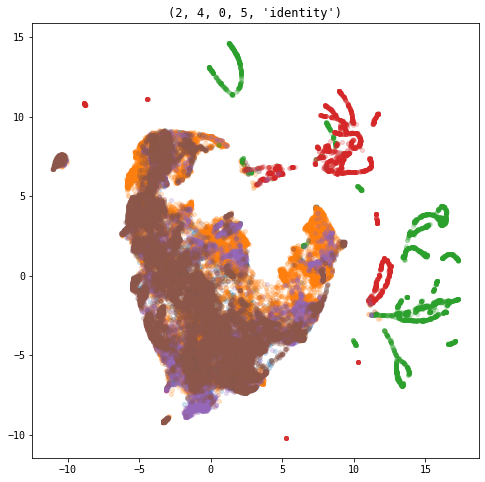

In [53]:
from umap import UMAP

reducer = UMAP(random_state=42)
usr = 36
fs_red_small = reducer.fit_transform(fs)
plt.figure(figsize=(8, 8))
for i in range(np.max(y)+1):
    plt.scatter(*fs_red_small[(y==i)].T, s=16., c=f'C{i}', alpha=0.2)
plt.title(key)

In [18]:
from sklearn.svm import SVC

rng = np.random.default_rng(42)
usrs_test = rng.choice(users, 6, replace=False)
mask_test = np.isin(preprocessor.seg_usrs, usrs_test)

X_train, y_train = fs[~mask_test], y[~mask_test]
X_test, y_test = fs[mask_test], y[mask_test]

model = SVC(C=1e3)
model.fit(X_train, y_train)
print(np.mean(model.predict(X_train) == y_train))
print(np.mean(model.predict(X_test) == y_test))

0.9485011529592621
0.7657629255989912


Text(0.5, 1.0, "(2, 1, 0, 20, 'identity')")

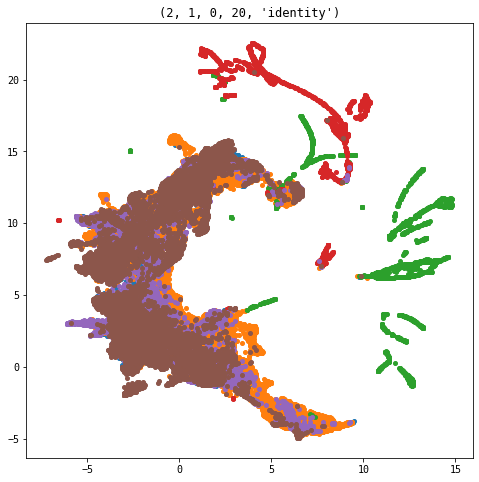

In [7]:
from umap import UMAP

reducer = UMAP(random_state=42)
usr = 36
fs_red_small = reducer.fit_transform(fs)
plt.figure(figsize=(8, 8))
for i in range(np.max(y)+1):
    plt.scatter(*fs_red_small[(y==i)].T, s=16., c=f'C{i}')
plt.title(key)

Text(0.5, 1.0, '(1, 0, 20)')

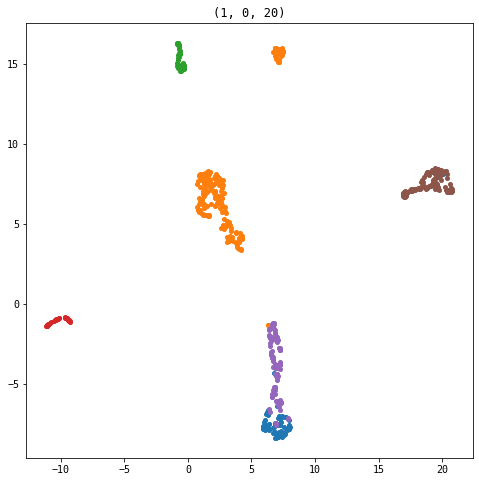

In [51]:
from umap import UMAP

reducer = UMAP(random_state=42)
usr = 36
fs_red_small = reducer.fit_transform(fs[(seg_usrs==usr)])
plt.figure(figsize=(8, 8))
for i in range(np.max(y)+1):
    plt.scatter(*fs_red_small[(y[seg_usrs==usr]==i)].T, s=16., c=f'C{i}')
plt.title(key)

Text(0.5, 1.0, '(1, 0, 20)')

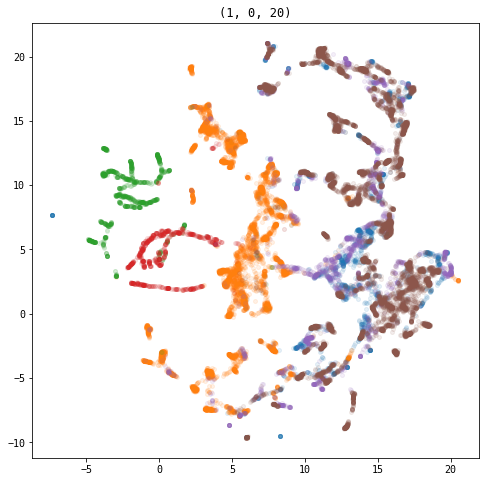

In [56]:
plt.figure(figsize=(8, 8))
for i in range(np.max(y)+1):
    plt.scatter(*fs_red[(y==i)].T, s=16., c=f'C{i}', alpha=0.1)
plt.title(key)

Text(0.5, 1.0, '(1, 2, 20)')

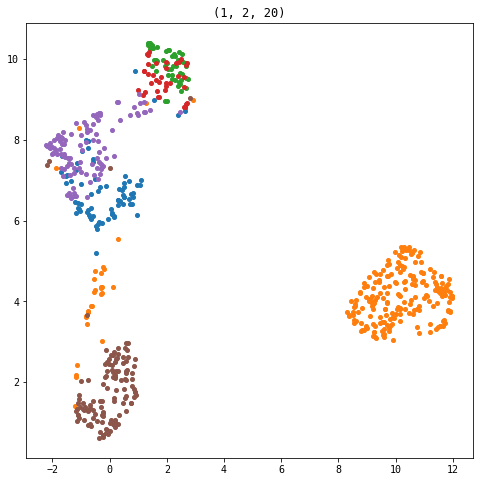

In [46]:
usr = 36
fs_red_small = reducer.fit_transform(fs[(seg_usrs==usr)])
plt.figure(figsize=(8, 8))
for i in range(np.max(y)+1):
    plt.scatter(*fs_red_small[(y[seg_usrs==usr]==i)].T, s=16., c=f'C{i}')
plt.title(key)

In [ ]:
df.groupby(['user', 'activity'])[['timestamp']].agg('count').reset_index().pivot(index='user', columns='activity').fillna(0)

timestamp                                             
activity Downstairs  Jogging  Sitting Standing Upstairs  Walking
user                                                            
1            2909.0  10871.0      0.0      0.0   3095.0  12759.0
2               0.0  11662.0      0.0      0.0      0.0  11647.0
3            3260.0  10845.0   1534.0   2721.0   3357.0  12795.0
4            1681.0    778.0   1158.0      0.0   1311.0   5424.0
5            3117.0   6173.0   1558.0   1463.0   2971.0  11679.0
6            1401.0   9386.0   1568.0    698.0   1636.0  11740.0
7            2210.0   8928.0   2456.0   2329.0   3545.0  10776.0
8            3243.0   9972.0   2573.0   3203.0   4357.0  16759.0
9               0.0      0.0      0.0      0.0      0.0  12801.0
10           3745.0  11924.0      0.0   1610.0   4231.0  12816.0
11           2070.0  12327.0      0.0      0.0   3820.0  11089.0
12           2734.0  12049.0   2140.0   1642.0   2510.0  10600.0
13           4127.0   9541.0   1030.0   1527.0   4526.0  12579.0
14           2842.0  13059.0      0.0      0.0   8098.0  13683.0
15           1666.0   8172.0      0.0      0.0   1886.0  10386.0
16           1359.0      0.0   2658.0   1875.0   1148.0  10806.0
17           3720.0   2887.0      0.0      0.0   5612.0   9603.0
18           2355.0   9157.0   1369.0   1826.0   2313.0  12335.0
19           2561.0   9617.0   2431.0   2095.0   4221.0  11606.0
20           4551.0   8443.0  15126.0   5266.0   4433.0  12106.0
21           3912.0   9364.0   1504.0   2768.0   4723.0  12239.0
22           3074.0   4769.0      0.0      0.0   4405.0   5806.0
23           1755.0  10738.0      0.0      0.0   4414.0   5683.0
24           2876.0  12124.0    669.0    533.0   2987.0   6191.0
25              0.0   6442.0      0.0      0.0      0.0   6884.0
26           3668.0  10843.0      0.0      0.0   3355.0  12415.0
27           3318.0   9262.0   2044.0   1608.0   2784.0  11602.0
28           2856.0      0.0      0.0   1253.0   2802.0  13399.0
29           4100.0   9485.0   2105.0   1409.0   4663.0  11968.0
30           3231.0      0.0   1242.0   2831.0   3564.0   9828.0
31           3817.0  13912.0   2046.0   2576.0   4605.0  16674.0
32           1938.0   7541.0   2802.0   1540.0   3595.0  12218.0
33           4493.0   2946.0   2907.0   1362.0   2214.0  14693.0
34           2627.0  10896.0   1256.0   1020.0   3549.0  10139.0
35              0.0  10761.0   1533.0   1012.0      0.0   6760.0
36           4118.0  11246.0   2328.0   1865.0   5308.0   6122.0

In [ ]:
# file_r = open(f'{_input_path}/WISDM_ar_v1.1_raw.txt', 'r')
# file_w = open(f'{_input_path}/WISDM_ar_v1.1_raw_modified.txt', 'w')
# for num, line in enumerate(file_r.readlines()):
#     if ',' not in line:
#         continue
#     line = line.replace(',;', ';').replace(';', '\n').replace('\n\n', '\n')
#     file_w.write(line)
# file_r.close()
# file_w.close()

In [230]:
# import itertools

# interval = 10
# for user, activity in itertools.product(sorted(df['user'].unique()), sorted(df['activity'].unique())):
#     mask = (df['user'] == user) & (df['activity'] == activity)
#     if not mask.any():
#         continue
#     time = df.loc[mask, 'timestamp']
#     m, M = time.min(), time.max()
#     for i in range( int((M-m)/5)+1 ):
#         t_lb, t_ub = m+interval*i, m+interval*(i+1)

#         mask_tmp = mask & (df['timestamp'] >= t_lb) & (df['timestamp'] <= t_ub)
#         if not mask_tmp.any():
#             continue
#         fig, axs = plt.subplots(nrows=3, figsize=(16, 9))
#         for j, ax in enumerate(axs):
#             ax.plot(df.loc[mask_tmp, 'timestamp'], df.loc[mask_tmp].iloc[:, 3+j])
#             ax.scatter(df.loc[mask_tmp, 'timestamp'], df.loc[mask_tmp].iloc[:, 3+j], s=16.)
#             ax.set_xlim(t_lb, t_ub); ax.set_ylim(-21, 21)
#             ax.grid()
#         title = f'User {user:0>2} {activity} - #{i+1:0>3}'
#         fig.suptitle(title, fontsize=20)
#         # plt.show() 
#         plt.savefig(f'../output/fragments/{title}.jpg')
#         plt.close()